# Lets Grow More

# LGMVIP OCTOBER 2021

# INTERNSHIP DOMAIN: DATA SCIENCE

# INTERN NAME: SAYAM KUMAR

# TASK LEVEL: Beginner

## Task 2: Stock Market Prediction And Forecasting using Stacked LSTM

## Importing the relevant libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import LSTM

## Importing the dataset

In [2]:
data = pd.read_csv('https://raw.githubusercontent.com/mwitiderrick/stockprice/master/NSE-TATAGLOBAL.csv')
stock_data = data.copy()
stock_data.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-09-28,234.05,235.95,230.20,233.50,233.75,3069914,7162.35
1,2018-09-27,234.55,236.80,231.10,233.80,233.25,5082859,11859.95
2,2018-09-26,240.00,240.00,232.50,235.00,234.25,2240909,5248.60
3,2018-09-25,233.30,236.75,232.00,236.25,236.10,2349368,5503.90
4,2018-09-24,233.55,239.20,230.75,234.00,233.30,3423509,7999.55


## Understanding the dataset

In [3]:
stock_data.shape

(2035, 8)

In [4]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2035 entries, 0 to 2034
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  2035 non-null   object 
 1   Open                  2035 non-null   float64
 2   High                  2035 non-null   float64
 3   Low                   2035 non-null   float64
 4   Last                  2035 non-null   float64
 5   Close                 2035 non-null   float64
 6   Total Trade Quantity  2035 non-null   int64  
 7   Turnover (Lacs)       2035 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 127.3+ KB


In [5]:
stock_data.describe()

,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
count,2035.000000,2035.000000,2035.000000,2035.000000,2035.00000,2.035000e+03,2035.000000
mean,149.713735,151.992826,147.293931,149.474251,149.45027,2.335681e+06,3899.980565
std,48.664509,49.413109,47.931958,48.732570,48.71204,2.091778e+06,4570.767877
min,81.100000,82.800000,80.000000,81.000000,80.95000,3.961000e+04,37.040000
25%,120.025000,122.100000,118.300000,120.075000,120.05000,1.146444e+06,1427.460000
50%,141.500000,143.400000,139.600000,141.100000,141.25000,1.783456e+06,2512.030000
75%,157.175000,159.400000,155.150000,156.925000,156.90000,2.813594e+06,4539.015000
max,327.700000,328.750000,321.650000,325.950000,325.75000,2.919102e+07,55755.080000


## Checking for null values if any

In [6]:
stock_data.isnull().sum()

Date                    0
Open                    0
High                    0
Low                     0
Last                    0
Close                   0
Total Trade Quantity    0
Turnover (Lacs)         0
dtype: int64

## Checking for duplicate values if any

In [7]:
stock_data[stock_data.duplicated()]

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)


## Pair Plot

<Figure size 1440x720 with 0 Axes>

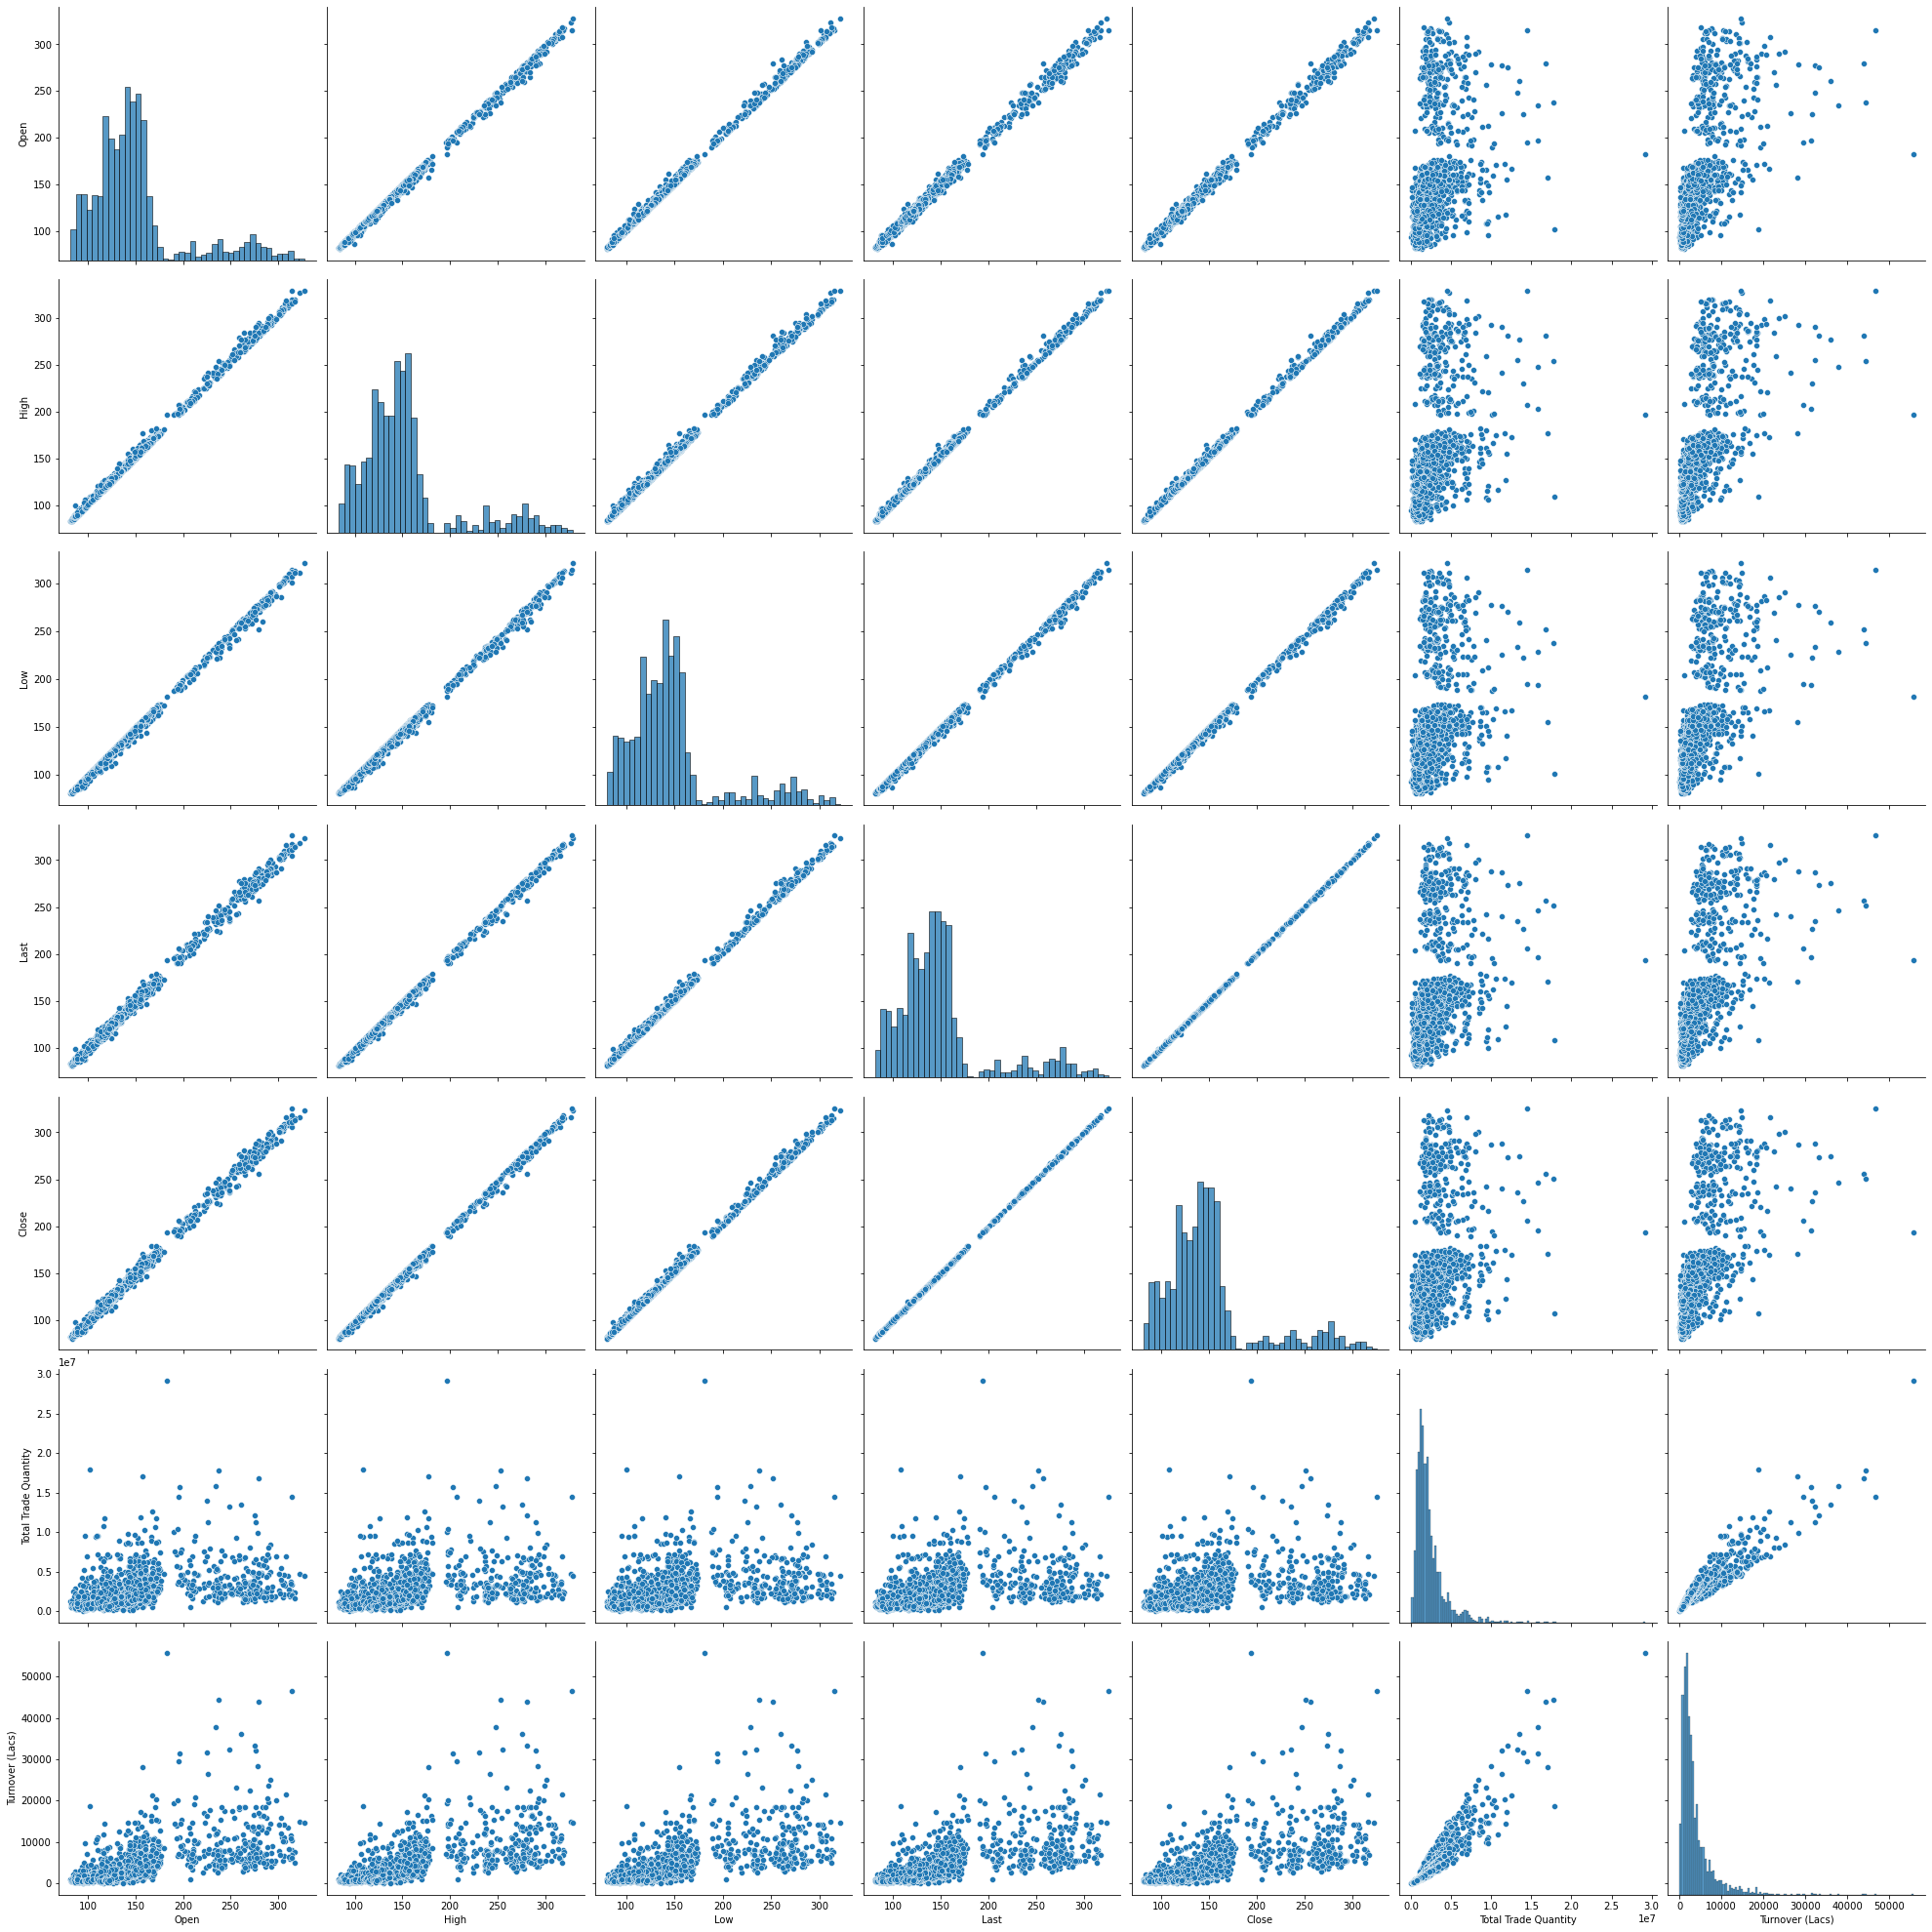

In [8]:
plt.figure(figsize=(20,10))
sns.pairplot(stock_data,height=4)

### Since LSTM is sensitive to the scale of data, so we can apply MinMax Scaler to transform our values between 0 and 1.


In [9]:
data_close = stock_data.reset_index()['Close']

In [10]:
scaler = MinMaxScaler(feature_range = (0,1))
data_close = scaler.fit_transform(np.array(data_close).reshape(-1,1))

In [11]:
data_close

array([[0.62418301],
       [0.62214052],
       [0.62622549],
       ...,
       [0.1621732 ],
       [0.16319444],
       [0.16584967]])

## Splitting the dataset into training and testing models

In [12]:
training_size = int(len(data_close) * 0.70)
test_size = len(data_close) - training_size
train_data, test_data = data_close[0:training_size,:], data_close[training_size:len(data_close),:1]

In [13]:
print('Size of training and testing : ',training_size,test_size)

Size of training and testing :  1424 611


## Function to convert an array of values to a dataset matrix

In [14]:
def create_dataset(dataset, time_step = 1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i+time_step, 0])
    return np.array(dataX), np.array(dataY)

## Reshaping into x=t,t+1,t+2,t+3 and y=t+4

In [15]:
time_step = 100
x_train, y_train = create_dataset(train_data, time_step)
x_test, y_test = create_dataset(test_data, time_step)

In [16]:
print('Shape of x train: ',x_train.shape)
print('Shape of y train: ',y_train.shape)

Shape of x train:  (1323, 100)
Shape of y train:  (1323,)


In [17]:
print('Shape of x test: ',x_test.shape)
print('Shape of y test: ',y_test.shape)

Shape of x test:  (510, 100)
Shape of y test:  (510,)


## Reshaping the input into the form of [samples, time steps, features] which is basically the primary requirement of LSTM.

In [18]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

## Creating LSTM Model

In [19]:
model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape = (100,1)))
model.add(LSTM(50, return_sequences = True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [21]:
model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 100, batch_size = 64, verbose = 1)

Epoch 1/100
21/21 [==============================] - 5s 233ms/step - loss: 0.0297 - val_loss: 0.0062
Epoch 2/100
21/21 [==============================] - 4s 171ms/step - loss: 0.0032 - val_loss: 0.0017
Epoch 3/100
21/21 [==============================] - 7s 311ms/step - loss: 0.0018 - val_loss: 0.0014
Epoch 4/100
21/21 [==============================] - 7s 316ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 5/100
21/21 [==============================] - 5s 238ms/step - loss: 0.0013 - val_loss: 0.0017
Epoch 6/100
21/21 [==============================] - 7s 334ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 7/100
21/21 [==============================] - 4s 195ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 8/100
21/21 [==============================] - 6s 274ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 9/100
21/21 [==============================] - 7s 326ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 10/100
21/21 [==============================] - 4s 175ms/step - loss: 0.0011 - val_lo

21/21 [==============================] - 7s 349ms/step - loss: 3.4556e-04 - val_loss: 3.3458e-04
Epoch 77/100
21/21 [==============================] - 4s 204ms/step - loss: 3.3824e-04 - val_loss: 2.5872e-04
Epoch 78/100
21/21 [==============================] - 7s 341ms/step - loss: 3.1484e-04 - val_loss: 2.8606e-04
Epoch 79/100
21/21 [==============================] - 5s 258ms/step - loss: 3.0677e-04 - val_loss: 2.3606e-04
Epoch 80/100
21/21 [==============================] - 6s 307ms/step - loss: 3.0663e-04 - val_loss: 2.7987e-04
Epoch 81/100
21/21 [==============================] - 7s 335ms/step - loss: 3.0078e-04 - val_loss: 2.5029e-04
Epoch 82/100
21/21 [==============================] - 5s 231ms/step - loss: 3.4027e-04 - val_loss: 2.2837e-04
Epoch 83/100
21/21 [==============================] - 7s 325ms/step - loss: 2.9335e-04 - val_loss: 2.9625e-04
Epoch 84/100
21/21 [==============================] - 5s 222ms/step - loss: 3.1261e-04 - val_loss: 2.9108e-04
Epoch 85/100
21/21 [===

## Predicting and examining performance metrics 

In [22]:
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

## Tranforming to original form

In [23]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

## Calculating RMSE performance metrics

In [24]:
math.sqrt(mean_squared_error(y_train, train_predict))

164.94880525284245

## Plotting and visualizing train and test predictions

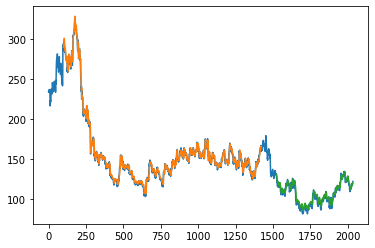

In [25]:
#Shift train prediction for plotting
look_back = 100
trainPredictPlot = np.empty_like(data_close)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[look_back:len(train_predict) + look_back, :] = train_predict

#Shift test prediction for plotting
testPredictPlot = np.empty_like(data_close)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(train_predict) + (look_back * 2)+1:len(data_close) - 1, :] = test_predict

#Plot baseline and predictions
plt.plot(scaler.inverse_transform(data_close))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

## 📌Predicting the stock price for the next 30 days

In [26]:
len(test_data), x_test.shape

(611, (510, 100, 1))

In [27]:
x_input = test_data[409:].reshape(1,-1)
x_input.shape

(1, 202)

In [28]:
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

In [29]:
lst_output=[]
n_steps=201
nextNumberOfDays = 30
i=0

while(i<nextNumberOfDays):
    
    if(len(temp_input)>100):
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

0 day input [0.0684232  0.06781046 0.0629085  0.0692402  0.0755719  0.07781863
 0.08088235 0.08843954 0.09395425 0.09599673 0.08660131 0.09027778
 0.08517157 0.08374183 0.07945261 0.09109477 0.09129902 0.08803105
 0.09681373 0.11417484 0.10498366 0.09987745 0.08537582 0.08047386
 0.06862745 0.06576797 0.06147876 0.07169118 0.07026144 0.0747549
 0.06821895 0.0692402  0.07066993 0.06801471 0.06678922 0.07414216
 0.07169118 0.08639706 0.08312908 0.06311275 0.0629085  0.05167484
 0.03186275 0.04003268 0.03860294 0.04105392 0.03390523 0.03125
 0.02634804 0.05861928 0.06311275 0.0620915  0.05535131 0.08455882
 0.05514706 0.06045752 0.0557598  0.0439134  0.02920752 0.02818627
 0.04718137 0.06045752 0.05861928 0.06168301 0.06699346 0.07087418
 0.0755719  0.07700163 0.10375817 0.10314542 0.10334967 0.10089869
 0.10437092 0.09803922 0.09722222 0.09783497 0.09579248 0.09109477
 0.09313725 0.08558007 0.09517974 0.11172386 0.12275327 0.12806373
 0.1313317  0.12479575 0.11090686 0.10743464 0.1162173

4 day output [[0.17321093]]
5 day input [0.07781863 0.08088235 0.08843954 0.09395425 0.09599673 0.08660131
 0.09027778 0.08517157 0.08374183 0.07945261 0.09109477 0.09129902
 0.08803105 0.09681373 0.11417484 0.10498366 0.09987745 0.08537582
 0.08047386 0.06862745 0.06576797 0.06147876 0.07169118 0.07026144
 0.0747549  0.06821895 0.0692402  0.07066993 0.06801471 0.06678922
 0.07414216 0.07169118 0.08639706 0.08312908 0.06311275 0.0629085
 0.05167484 0.03186275 0.04003268 0.03860294 0.04105392 0.03390523
 0.03125    0.02634804 0.05861928 0.06311275 0.0620915  0.05535131
 0.08455882 0.05514706 0.06045752 0.0557598  0.0439134  0.02920752
 0.02818627 0.04718137 0.06045752 0.05861928 0.06168301 0.06699346
 0.07087418 0.0755719  0.07700163 0.10375817 0.10314542 0.10334967
 0.10089869 0.10437092 0.09803922 0.09722222 0.09783497 0.09579248
 0.09109477 0.09313725 0.08558007 0.09517974 0.11172386 0.12275327
 0.12806373 0.1313317  0.12479575 0.11090686 0.10743464 0.11621732
 0.11683007 0.11764706 

8 day output [[0.17847148]]
9 day input [0.09599673 0.08660131 0.09027778 0.08517157 0.08374183 0.07945261
 0.09109477 0.09129902 0.08803105 0.09681373 0.11417484 0.10498366
 0.09987745 0.08537582 0.08047386 0.06862745 0.06576797 0.06147876
 0.07169118 0.07026144 0.0747549  0.06821895 0.0692402  0.07066993
 0.06801471 0.06678922 0.07414216 0.07169118 0.08639706 0.08312908
 0.06311275 0.0629085  0.05167484 0.03186275 0.04003268 0.03860294
 0.04105392 0.03390523 0.03125    0.02634804 0.05861928 0.06311275
 0.0620915  0.05535131 0.08455882 0.05514706 0.06045752 0.0557598
 0.0439134  0.02920752 0.02818627 0.04718137 0.06045752 0.05861928
 0.06168301 0.06699346 0.07087418 0.0755719  0.07700163 0.10375817
 0.10314542 0.10334967 0.10089869 0.10437092 0.09803922 0.09722222
 0.09783497 0.09579248 0.09109477 0.09313725 0.08558007 0.09517974
 0.11172386 0.12275327 0.12806373 0.1313317  0.12479575 0.11090686
 0.10743464 0.11621732 0.11683007 0.11764706 0.12888072 0.12847222
 0.13337418 0.14236111 

13 day output [[0.184968]]
14 day input [0.07945261 0.09109477 0.09129902 0.08803105 0.09681373 0.11417484
 0.10498366 0.09987745 0.08537582 0.08047386 0.06862745 0.06576797
 0.06147876 0.07169118 0.07026144 0.0747549  0.06821895 0.0692402
 0.07066993 0.06801471 0.06678922 0.07414216 0.07169118 0.08639706
 0.08312908 0.06311275 0.0629085  0.05167484 0.03186275 0.04003268
 0.03860294 0.04105392 0.03390523 0.03125    0.02634804 0.05861928
 0.06311275 0.0620915  0.05535131 0.08455882 0.05514706 0.06045752
 0.0557598  0.0439134  0.02920752 0.02818627 0.04718137 0.06045752
 0.05861928 0.06168301 0.06699346 0.07087418 0.0755719  0.07700163
 0.10375817 0.10314542 0.10334967 0.10089869 0.10437092 0.09803922
 0.09722222 0.09783497 0.09579248 0.09109477 0.09313725 0.08558007
 0.09517974 0.11172386 0.12275327 0.12806373 0.1313317  0.12479575
 0.11090686 0.10743464 0.11621732 0.11683007 0.11764706 0.12888072
 0.12847222 0.13337418 0.14236111 0.14093137 0.13970588 0.13827614
 0.13541667 0.13010621 

19 day output [[0.19225462]]
20 day input [0.10498366 0.09987745 0.08537582 0.08047386 0.06862745 0.06576797
 0.06147876 0.07169118 0.07026144 0.0747549  0.06821895 0.0692402
 0.07066993 0.06801471 0.06678922 0.07414216 0.07169118 0.08639706
 0.08312908 0.06311275 0.0629085  0.05167484 0.03186275 0.04003268
 0.03860294 0.04105392 0.03390523 0.03125    0.02634804 0.05861928
 0.06311275 0.0620915  0.05535131 0.08455882 0.05514706 0.06045752
 0.0557598  0.0439134  0.02920752 0.02818627 0.04718137 0.06045752
 0.05861928 0.06168301 0.06699346 0.07087418 0.0755719  0.07700163
 0.10375817 0.10314542 0.10334967 0.10089869 0.10437092 0.09803922
 0.09722222 0.09783497 0.09579248 0.09109477 0.09313725 0.08558007
 0.09517974 0.11172386 0.12275327 0.12806373 0.1313317  0.12479575
 0.11090686 0.10743464 0.11621732 0.11683007 0.11764706 0.12888072
 0.12847222 0.13337418 0.14236111 0.14093137 0.13970588 0.13827614
 0.13541667 0.13010621 0.12254902 0.12479575 0.13848039 0.14011438
 0.13888889 0.1354166

25 day output [[0.19879448]]
26 day input [0.06147876 0.07169118 0.07026144 0.0747549  0.06821895 0.0692402
 0.07066993 0.06801471 0.06678922 0.07414216 0.07169118 0.08639706
 0.08312908 0.06311275 0.0629085  0.05167484 0.03186275 0.04003268
 0.03860294 0.04105392 0.03390523 0.03125    0.02634804 0.05861928
 0.06311275 0.0620915  0.05535131 0.08455882 0.05514706 0.06045752
 0.0557598  0.0439134  0.02920752 0.02818627 0.04718137 0.06045752
 0.05861928 0.06168301 0.06699346 0.07087418 0.0755719  0.07700163
 0.10375817 0.10314542 0.10334967 0.10089869 0.10437092 0.09803922
 0.09722222 0.09783497 0.09579248 0.09109477 0.09313725 0.08558007
 0.09517974 0.11172386 0.12275327 0.12806373 0.1313317  0.12479575
 0.11090686 0.10743464 0.11621732 0.11683007 0.11764706 0.12888072
 0.12847222 0.13337418 0.14236111 0.14093137 0.13970588 0.13827614
 0.13541667 0.13010621 0.12254902 0.12479575 0.13848039 0.14011438
 0.13888889 0.13541667 0.14011438 0.1380719  0.13071895 0.13071895
 0.12867647 0.1184640

In [30]:
day_new = np.arange(1,101)
day_pred = np.arange(101,131)

In [31]:
df = data_close.tolist()
df.extend(lst_output)

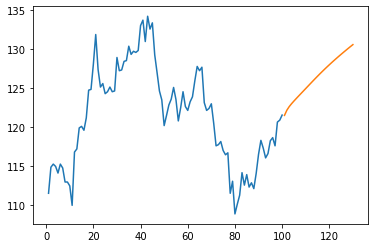

In [32]:
plt.plot(day_new, scaler.inverse_transform(data_close[1935:]))
plt.plot(day_pred, scaler.inverse_transform(lst_output))

# THANK YOU